    %pip install selectivesearch

In [ ]:
from skimage.segmentation import felzenszwalb
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
%pip install Pillow


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [77]:
import cv2,selectivesearch,numpy as np
from PIL import Image,ImageDraw
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[logging.FileHandler('app.log'), logging.StreamHandler()])
logger = logging.getLogger(__name__)
%matplotlib inline

2025-02-24 23:19:52,785 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [82]:
path = 'C:\\Users\\MASOUD\\Pictures\\cars\\drone.jpg'

In [83]:
img = cv2.imread(path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

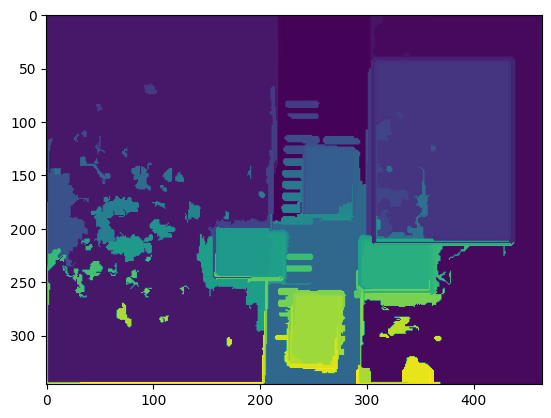

In [86]:
segments_fz = felzenszwalb(img, scale=200)
plt.imshow(segments_fz)

In [84]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img,scale=20,min_size=10)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
        return candidates

2025-02-24 23:20:49,731 - INFO - x=306;y=42;w=129;h=171


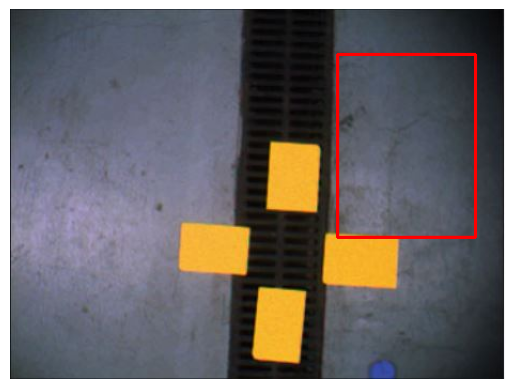

In [85]:
candidates = extract_candidates(img)
len(candidates)
for candidate in candidates:
    x , y , w , h = candidate
    logger.info(f'x={x};y={y};w={w};h={h}')
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)


plt.imshow(img)
plt.axis('off')
plt.show()

### In the following example please note that direction of vertical axis is downward, the deeper pixel the higher y coordinate

In [29]:
def calculate_iou(boxA,boxB,epsilion = 1e-5):
    # boxA and boxB are in the format (x1, y1, x2, y2)
    # where (x1, y1) is the top-left corner and (x2, y2) is the bottom-right corner

    # Calculate the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection
    inter_width = max(0, xB - xA)
    inter_height = max(0, yB - yA)
    inter_area = inter_width * inter_height

    # Compute the area of both boxes
    boxA_area = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxB_area = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Compute the area of union
    union_area = boxA_area + boxB_area - inter_area

    # Compute the IoU
    iou = inter_area / union_area if union_area > 0 else 0

    return iou

In [30]:
boxA = (1,3,3,1)
boxB = (2,4,4,2)

intersection = calculate_iou(boxA,boxB)
logger.info(intersection)

2025-03-06 02:41:52,048 - INFO - 0


In [1]:
import selectivesearch
from torch import cuda
import cv2
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models,datasets
from torchvision.ops import nms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd,numpy as np
from pandas import DataFrame as df
device = 'cuda' if cuda.is_available() else 'cpu'
import logging
logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[logging.FileHandler('app.log'), logging.StreamHandler()])
logger = logging.getLogger(__name__)
%matplotlib inline

2025-03-11 21:42:41,868 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-03-11 21:42:41,893 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [2]:
IMAGE_FOLDER = './data/open-images-bus-trucks/open-images-bus-trucks/images'

class OpenImages(Dataset):
    def __init__(self,df,image_folder=IMAGE_FOLDER):
        self.root = image_folder
        self.df = df
        self.unique_images = df['ImageID'].unique()

    def __len__(self):
        return len(self.unique_images)
    
    def __getitem__(self, index):
        image_id = self.unique_images[index]
        image_path = f'{self.root}/{image_id}.jpg'
        #READ IMAGE AND CONVERT IT TO RGB
        image = cv2.imread(image_path)[...,::-1]
        h,w,_ = image.shape
        image_df = df[df['ImageID']==image_id]
        boxes = image_df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes*np.array([w,h,w,h])).astype(np.uint16).tolist()[0]
        classes = image_df['LabelName'].values.tolist()
        return image,boxes,classes,image_path

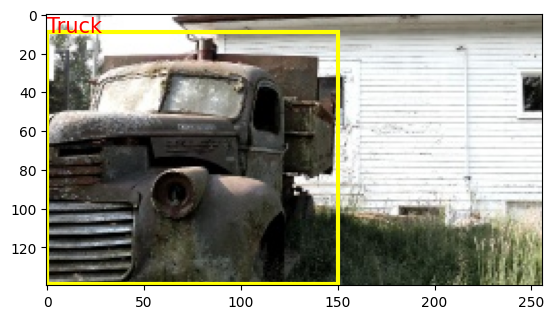

In [9]:
df = pd.read_csv('./data/open-images-bus-trucks/open-images-bus-trucks/df.csv')
ds = OpenImages(df)
image,boxes,classes,_ = ds[8]
bottom_left = boxes[0],boxes[1]
box_width = boxes[2] - boxes[0]
box_height = boxes[3] - boxes[1]
fig,ax = plt.subplots()
ax.imshow(image)
rectangle = patches.Rectangle(
    bottom_left,width=box_width,height=box_height,linewidth = 3,edgecolor= 'yellow',
    facecolor='none'
    )
ax.add_patch(rectangle)
text_x = boxes[0] 
text_y = boxes[1] 
ax.text(text_x,text_y ,classes[0],color='red',fontsize=15)
plt.show()

In [4]:
def extract_candidates(img):
    img_lbl,regions = selectivesearch.selective_search(img,
    scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
    x, y, w, h = r['rect']
    candidates.append(list(r['rect']))
    return candidates
def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

In [10]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [],[],[],[],[],[]

In [ ]:
N = 500
for ix, (im,bbx,clss,fpath) in enumerate(ds):
    if ix==N:
        break
    W,H,_ = im.shape
    candidates = extract_candidates(im)
    candidates = np.array([x,y,x+w,y+h for  x,y,w, h in candidates])
    ious, rois, clss, deltas = [], [], [], []